In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from datasets import load_dataset

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
os.environ['TOKENIZERS_PARALLELISM'] = 'true'

## Модель и токенайзер

In [3]:
from transformers import  LongT5ForConditionalGeneration,  AutoTokenizer

In [4]:
model_checkpoint = "google/long-t5-tglobal-base"

model = LongT5ForConditionalGeneration.from_pretrained(model_checkpoint)
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

## Данные

In [5]:
dataset = load_dataset("cnn_dailymail", "3.0.0")

In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 287113
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 13368
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 11490
    })
})

#### Фильтрация:

In [7]:
def filter_examples(example):
    input_tokens = tokenizer(example['article'], truncation=True, padding='do_not_pad').input_ids
    return 512 <= len(input_tokens) <= 1024

train_dataset = dataset['train'].filter(filter_examples)
val_dataset = dataset['validation'].filter(filter_examples)

train_dataset = train_dataset.select(range(2500))
val_dataset = val_dataset.select(range(100))


In [8]:
train_dataset

Dataset({
    features: ['article', 'highlights', 'id'],
    num_rows: 2500
})

In [9]:
val_dataset

Dataset({
    features: ['article', 'highlights', 'id'],
    num_rows: 100
})

In [10]:
max_input_length = 1024
max_target_length = 512

def preprocess_function(examples):
    inputs = [doc for doc in examples["article"]]
    model_inputs = tokenizer(inputs, max_length=max_input_length, padding=True, truncation=True)

    labels = tokenizer(text_target=examples["highlights"], max_length=max_target_length, padding=True, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [11]:
import random
preprocess_function(train_dataset[random.randint(0, len(train_dataset))])

{'input_ids': [[41, 1, 0], [205, 1, 0], [445, 1, 0], [445, 1, 0], [3, 61, 1], [1, 0, 0], [3, 18, 1], [3, 18, 1], [1, 0, 0], [391, 1, 0], [3, 32, 1], [3, 115, 1], [3, 15, 1], [3, 52, 1], [3, 17, 1], [3, 32, 1], [1, 0, 0], [71, 1, 0], [3, 7, 1], [3, 75, 1], [3, 15, 1], [3, 29, 1], [3, 75, 1], [3, 23, 1], [3, 32, 1], [1, 0, 0], [3, 107, 1], [3, 9, 1], [3, 7, 1], [1, 0, 0], [3, 40, 1], [3, 23, 1], [3, 208, 1], [3, 15, 1], [3, 26, 1], [1, 0, 0], [3, 23, 1], [3, 29, 1], [1, 0, 0], [3, 17, 1], [3, 107, 1], [3, 15, 1], [1, 0, 0], [445, 1, 0], [3, 15, 1], [3, 210, 1], [1, 0, 0], [411, 1, 0], [3, 52, 1], [3, 40, 1], [3, 15, 1], [3, 9, 1], [3, 29, 1], [3, 7, 1], [1, 0, 0], [3, 9, 1], [3, 52, 1], [3, 15, 1], [3, 9, 1], [1, 0, 0], [3, 89, 1], [3, 32, 1], [3, 52, 1], [1, 0, 0], [220, 1, 0], [3, 632, 1], [1, 0, 0], [3, 63, 1], [3, 15, 1], [3, 9, 1], [3, 52, 1], [3, 7, 1], [3, 6, 1], [1, 0, 0], [204, 1, 0], [505, 1, 0], [1, 0, 0], [3, 32, 1], [3, 89, 1], [1, 0, 0], [3, 17, 1], [3, 107, 1], [3, 15, 1],

In [ ]:
train_tokenized = train_dataset.map(preprocess_function, batched=True)
val_tokenized = val_dataset.map(preprocess_function, batched=True)

## Обучение:

In [13]:
from transformers import DataCollatorForSeq2Seq
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [28]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments


training_args = Seq2SeqTrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=val_tokenized,
    data_collator=data_collator,
    tokenizer=tokenizer
)
trainer.train()

Step,Training Loss
10,23.858900
20,25.815900
30,23.833300
40,24.603300
50,21.519700
60,22.542000
70,20.949500
80,23.720100
90,21.744700
100,19.892800


TrainOutput(global_step=3750, training_loss=2.0883456199645996, metrics={'train_runtime': 953.6883, 'train_samples_per_second': 7.864, 'train_steps_per_second': 3.932, 'total_flos': 1.02681737856e+16, 'train_loss': 2.0883456199645996, 'epoch': 3.0})

Про выбор гиперпараметров: в целом можно использовать просто стандартные значения: из-за того что датасет маленький, сетка очень быстро сходится (лосс на минимуме уже после 300 с копейками батчей). Поэтому learning rate было решено оставить со значением по умолчанию (оно чаще всего и работает лучше всего). По per_device_train_batch_size - стоит 2, но в целом помещается чуть большой. Особой разницы в обучении с разными батчами не получилось заметить. weight_decay - тоже стандартное общепринятое значение регуляризации. Все сошлось с первого раза, поэтому набор гиперпараметров и их значений адекватный.

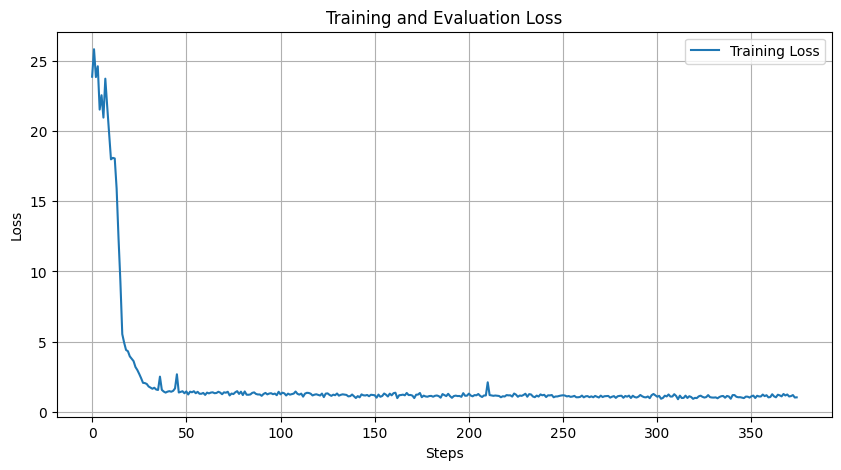

In [32]:
training_loss = trainer.state.log_history
steps = list(range(1, len(training_loss) + 1))

train_losses = [x['loss'] for x in training_loss if 'loss' in x]

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training and Evaluation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
from transformers import pipeline
from rouge_score import rouge_scorer
summarizer = pipeline("summarization", model=model, tokenizer=tokenizer)

def generate_summary(text):
    return summarizer(text, max_length=60, min_length=10, do_sample=False)[0]['summary_text']

# metrics on validation dataset
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
scores = []
for i in range(len(val_dataset)):
    prediction = generate_summary(val_dataset[i]['article'])
    target = val_dataset[i]['highlights']
    scores.append(scorer.score(target, prediction))

rouge1 = np.mean([score['rouge1'].fmeasure for score in scores])
rouge2 = np.mean([score['rouge2'].fmeasure for score in scores])
rougeL = np.mean([score['rougeL'].fmeasure for score in scores])

print(f"Rouge1: {rouge1:.4f}")
print(f"Rouge2: {rouge2:.4f}")
print(f"RougeL: {rougeL:.4f}")

Rouge1: 0.3008
Rouge2: 0.1063
RougeL: 0.2185


In [24]:
for i in range(5):
    prediction = generate_summary(val_dataset[i]['article'])
    target = val_dataset[i]['highlights']
    print(f"Article: {val_dataset[i]['article']}")
    print(f"Prediction: {prediction}")
    print(f"Target: {target}")
    print("")

Article: (CNN)French striker Bafetimbi Gomis, who has a history of fainting, said he is now "feeling well" after collapsing during Swansea's 3-2 loss at Tottenham in the Premier League on Wednesday. The worrying incident occurred in the first half at White Hart Lane -- after Tottenham scored in the seventh minute -- but the 29-year-old left the pitch conscious following about five minutes of treatment. The Guardian added that he was wearing an oxygen mask. Play was temporarily stopped before resuming. As the match progressed, Swansea tweeted that Gomis was "fine," with manager Garry Monk using the same word to describe Gomis' condition. Gomis spent the night in hospital as a precaution, Swansea said on its website. "I wanted to reassure you concerning my health," Gomis told the website. "It actually looks much scarier than it is physically dangerous, and I am feeling well now. "I have been under a great deal of stress and fatigue due to my father's health, which requires me to go back 